In [1]:
import pydicom,kornia,skimage
from fastai.vision.all import *
from fastai.medical.imaging import *
from torchvision.utils import save_image
import seaborn as sns

from fmi.pipeline import *
from fmi.explore import *
from fmi.preprocessing import *
from fmi.examine import *
from itertools import chain
import imageio
from sklearn.model_selection import train_test_split

import timm
from wwf.vision.timm import *

matplotlib.rcParams['image.cmap'] = 'rainbow_r'

In [2]:
source = untar_data(URLs.SIIM_SMALL)
p_items = get_dicom_files(f'{source}/train')
df = pd.read_csv(f'{source}/labels.csv')
p_items

(#250) [Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000000.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000002.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000005.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000006.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000007.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000008.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000009.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000011.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000012.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000014.dcm')...]

In [3]:
system_info()

fastai Version: 2.1.5
fastcore Version: 1.3.6
python Version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
torchvision: 0.8.1
torch version: 1.7.0

Cuda: True
cuda Version: 11.0
GPU: GeForce GTX 1060

pydicom Version: 2.1.1
kornia Version: 0.2.0


In [4]:
dcmread(p_items[0])

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [5]:
get_image_info(p_items[0])

(0008, 0060) Modality                            CS: 'CR'
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0030) Pixel Spacing                       DS: [0.168, 0.168]
No SliceThickness
(0028, 0100) Bits Allocated                      US: 8
No Rescale Intercept
No Rescale Slope


In [6]:
get_pii(p_items[0])

(0010, 0010) Patient's Name                      PN: '16d7f894-55d7-4d95-8957-d18987f0e981'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '62'
No Image Comments


In [7]:
trn,val = RandomSplitter()(p_items)

In [8]:
trn, val

((#200) [210,74,136,0,246,112,229,58,41,66...],
 (#50) [176,228,234,14,47,57,142,207,203,24...])

In [9]:
t, v, _, _, _, _ = dicomsplit(valid_pct=0.2, seed=7)(p_items)

In [10]:
len(t), len(v)

(200, 50)

Train: 200 
 Original Validation: 50 
 Updated Validation: 50


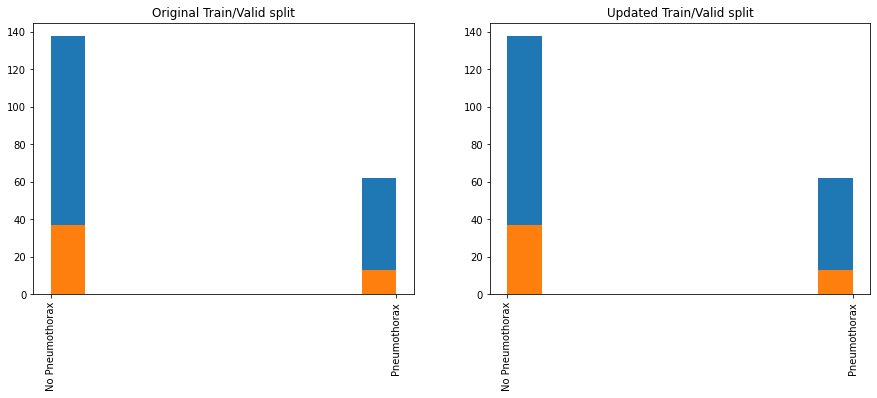

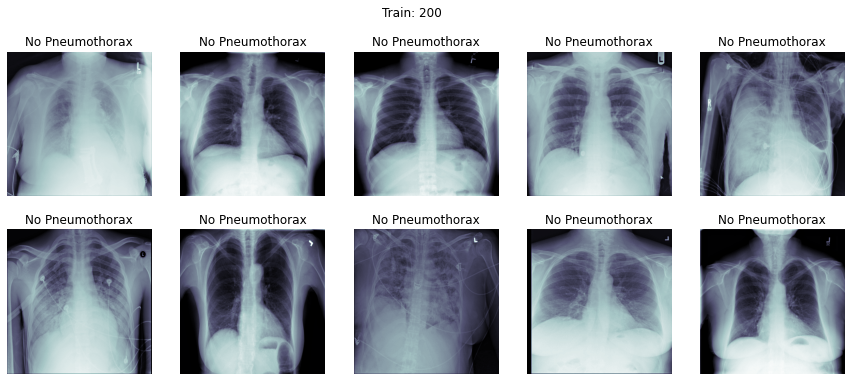

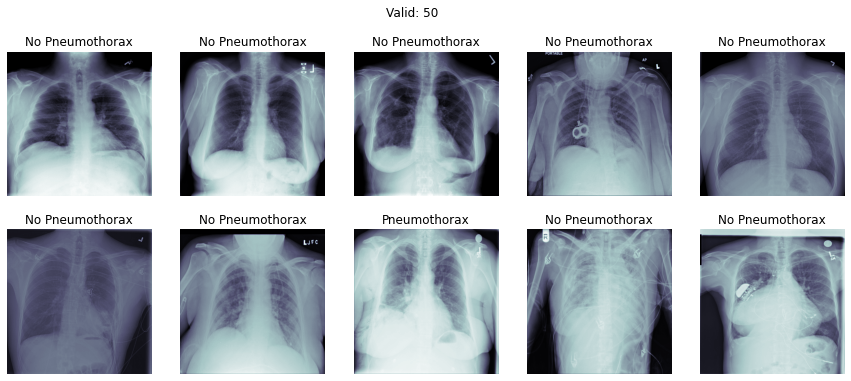

In [11]:
check_duplicate(p_items, valid_pct=0.2, seed=78)

In [12]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:source/f"{x[0]}",
                   get_y=lambda x:x[1],
                   item_tfms = Resize(512),
                   batch_tfms = [*aug_transforms(size=496, max_warp=0), Normalize.from_stats(*imagenet_stats)])

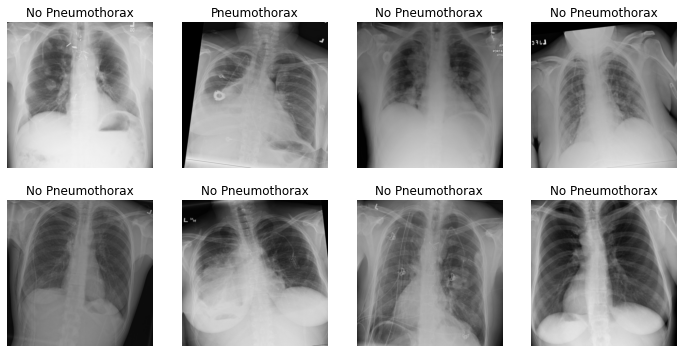

In [13]:
dls = pneumothorax.dataloaders(df.values, bs=8, num_workers=0)
dls.show_batch(max_n=16)

In [14]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, cbs=[SaveModelCallback, ShowGraphCallback])

epoch,train_loss,valid_loss,accuracy,time
0,1.157194,0.843156,0.580000,00:22
1,1.127780,0.550937,0.720000,00:19
2,0.930974,0.474968,0.820000,00:19
3,0.823269,0.581708,0.780000,00:19
4,0.813836,0.623166,0.800000,00:20


Better model found at epoch 0 with valid_loss value: 0.8431555032730103.


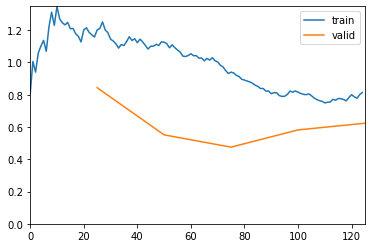

Better model found at epoch 1 with valid_loss value: 0.5509366393089294.
Better model found at epoch 2 with valid_loss value: 0.47496768832206726.


c:\users\avird\anaconda3\envs\fastainew\lib\site-packages\fastai\learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [15]:
learn.fit_one_cycle(5)

In [16]:
learn.save('one')

Path('models/one.pth')

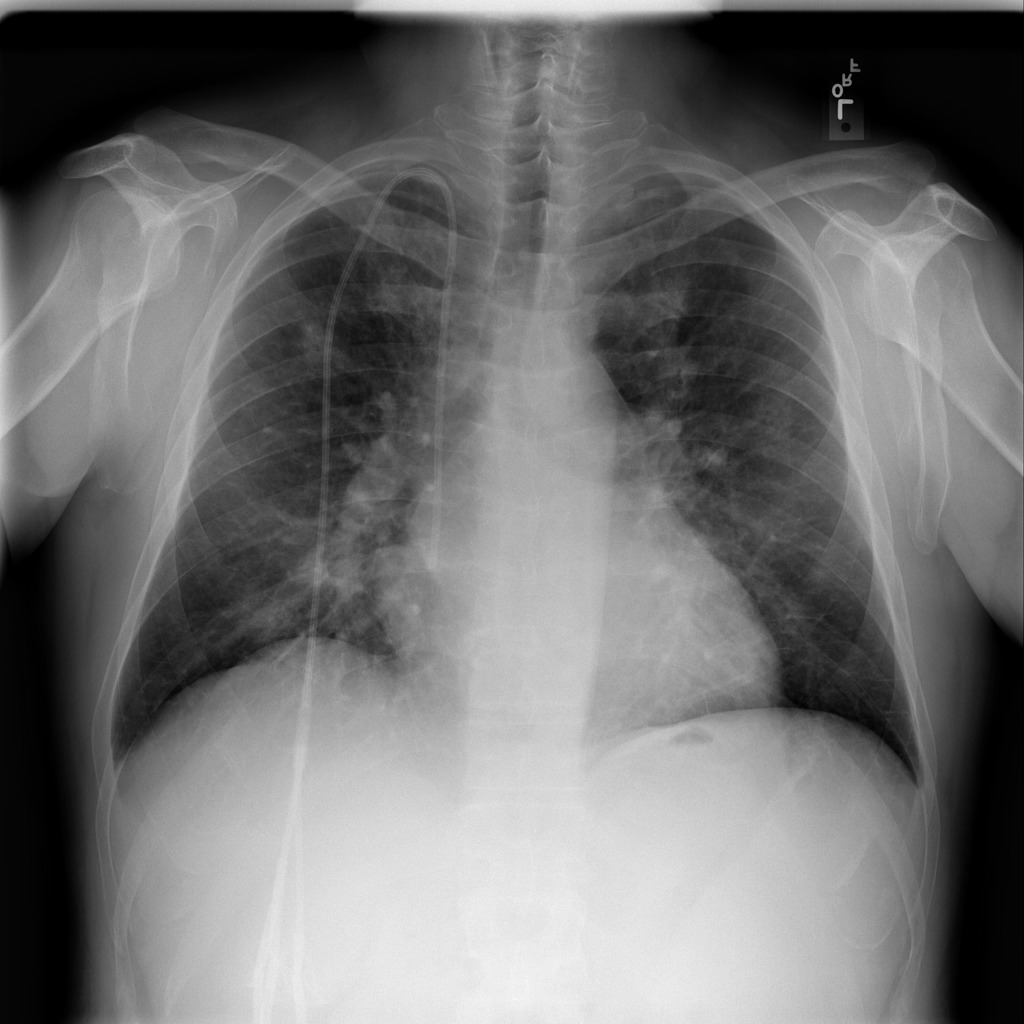

In [16]:
test_image = PILDicom.create(p_items[97])
test_image

In [18]:
learn.model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Number of Layers: 90


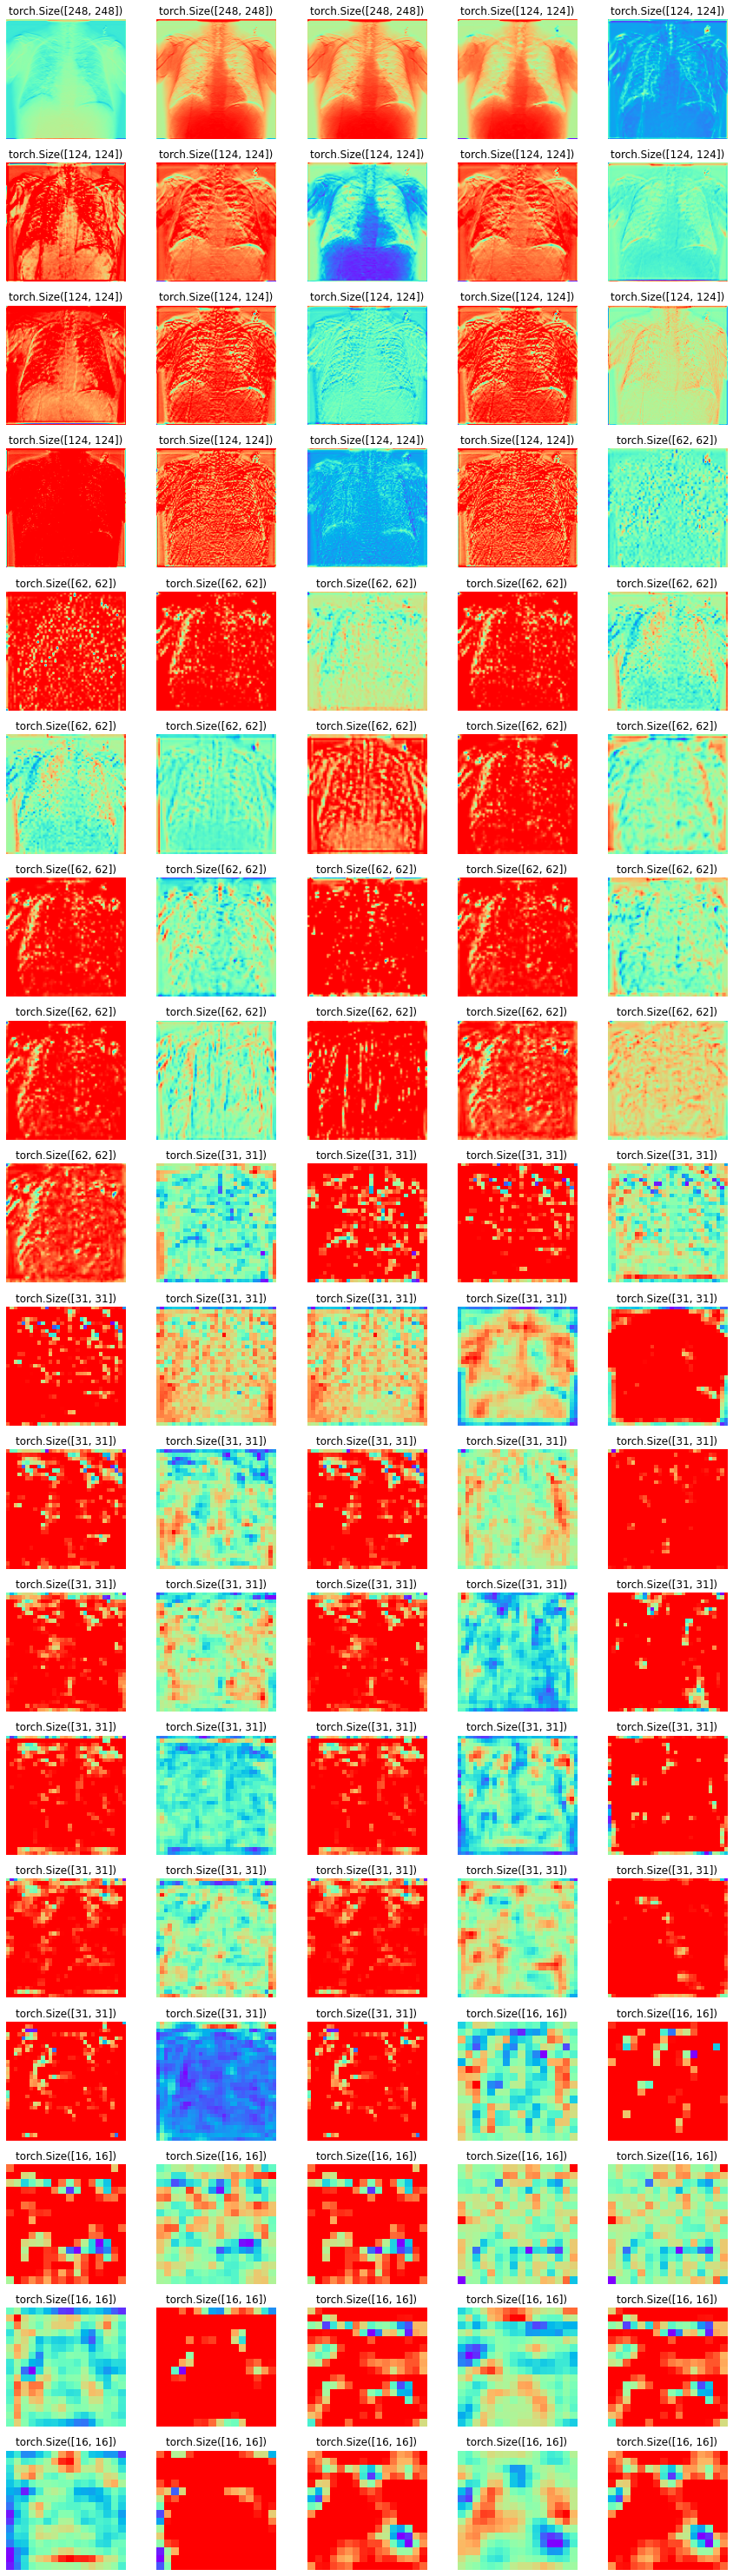

In [19]:
visualize_layers(p_items[97], learn, nrows=18, ncols=5)